### imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import dill
import datetime

import torch
from PriceFNN import PriceFNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import shap
from shap_flow_util import rename_nodes_in_graph_FR, save_graph_thesis, read_csv_incl_timeindex, plot_dependency, plot_bar_mean_abs_asv, plot_bar_mean_abs_shap
from shap_flow_util import get_mean_shap_attr

# load credit flow, models, etc.

In [2]:
# load credit flow, models, background and foreground values from files
periods = [('2015-01-08', '2021-09-30'),
                ('2021-10-01', '2023-12-31'),
                ('2015-01-08', '2023-12-31')]
version = 'v5'
date = datetime.datetime.now().strftime("%Y-%m-%d")
layer_sizes = [(30, 15),
               (30, 15),
               (10, 15)]

fnn_creditflow_list = []
fnn_model_list = []
fnn_X_scalers = []
fnn_y_scalers = []
fnn_bg_list = []
fnn_fg_list = []
for i, (start_date, end_date) in enumerate(periods):
    model_name = 'pytorch_start_{}_end_{}'.format(start_date, end_date)
    cf_file_name = 'pytorch_start_{}_end_{}'.format(start_date, end_date, version)
    with open('./credit_flow/{}/{}.pkl'.format(version, cf_file_name), 'rb') as file:
        loaded_cf = dill.load(file)
        rename_nodes_in_graph_FR(loaded_cf)
        fnn_creditflow_list.append(loaded_cf)

    l1, l2 = layer_sizes[i]
    config = {
                "input_size": 20,
                "l1_size": l1,
                "l2_size": l2,
                "output_size": 1,
                "learning_rate": 0.001,
                "do": 0
            }
    model = PriceFNN(config)
    model.load_state_dict(torch.load("./models/{}/pytorch/best/model_{}_l1_{}_l2_{}.pkl".format(version, model_name, l1, l2)))
    model.eval()
    fnn_model_list.append(model)

    X_train = read_csv_incl_timeindex('./data/{}/X_train_pytorch_start_{}_end_{}.csv'.format(version, start_date, end_date))
    y_train = read_csv_incl_timeindex('./data/{}/y_train_pytorch_start_{}_end_{}.csv'.format(version, start_date, end_date))
    X_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    X_col = X_train.columns
    X_scaler = X_scaler.fit(X_train[X_col].values)
    fnn_X_scalers.append(X_scaler)
    y_col = y_train.columns
    y_scaler = y_scaler.fit(y_train[y_col].values)
    fnn_y_scalers.append(y_scaler)
    fnn_bg_list.append(read_csv_incl_timeindex('./data/{}/bg_pytorch_start_{}_end_{}.csv'.format(version, start_date, end_date)))
    fnn_fg_list.append(read_csv_incl_timeindex('./data/{}/fg_pytorch_start_{}_end_{}.csv'.format(version, start_date, end_date)))

# Shapley flow

## Plots of mean absolute credit

### Mean absolute edge credit

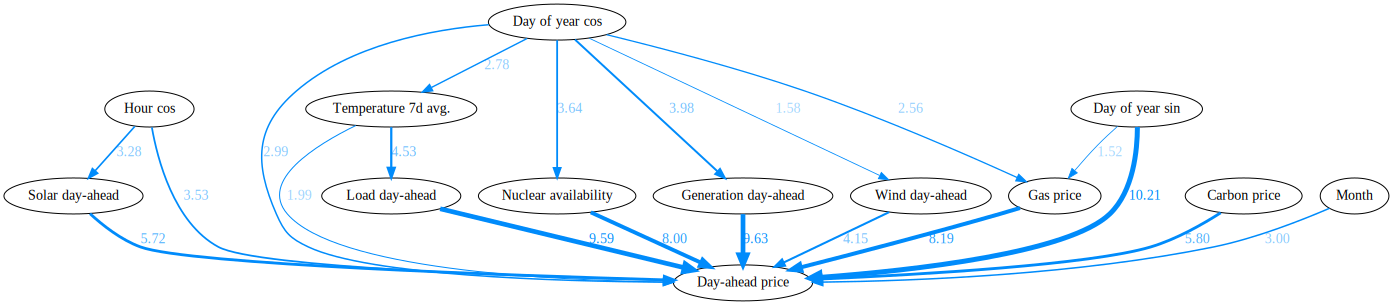

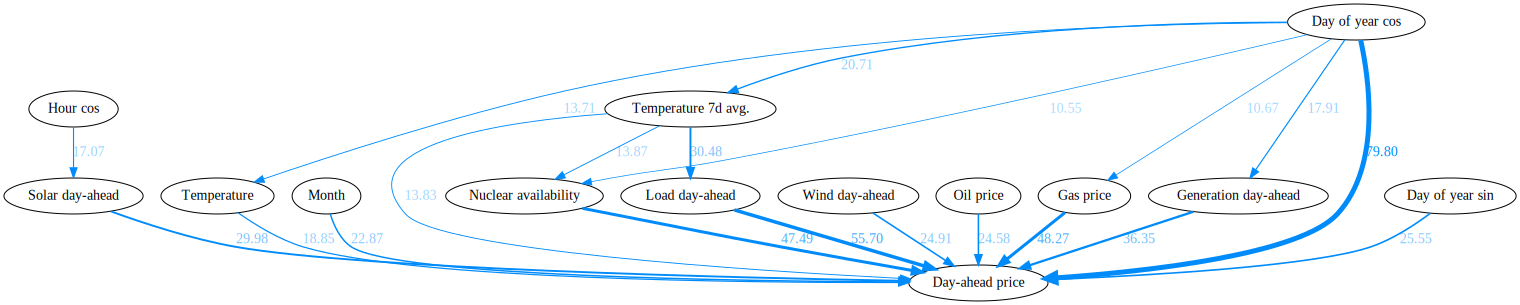

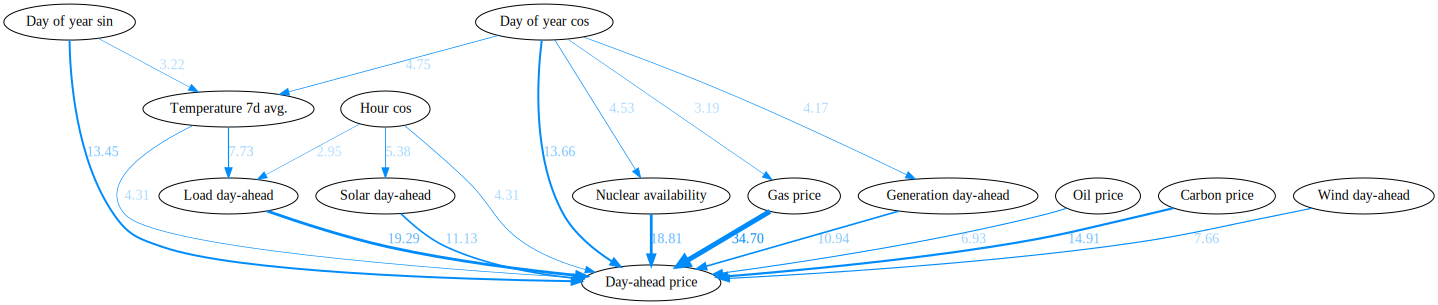

In [23]:
max_display = 20
for model_index in range(3):
    g = fnn_creditflow_list[model_index].draw(idx=-1,
                    show_fg_val=True,
                    max_display=max_display)
    start_date, end_date = periods[model_index]
    g.graph_attr['rankdir']='LR' # change layout from top-bottom to left-right
    save_graph_thesis(g, './plots/FNN_flow_mean-abs_show-{}_{}_{}_{}'.format(max_display, start_date, end_date, model_index), format='pdf', view=True)

### Mean absolute ASV

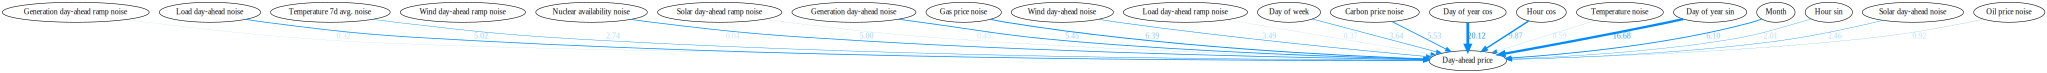

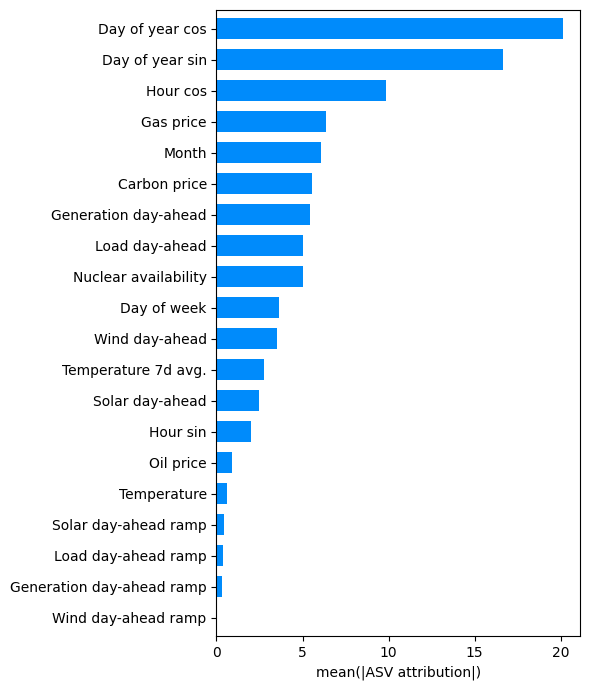

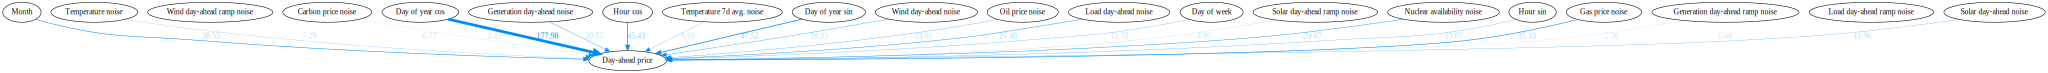

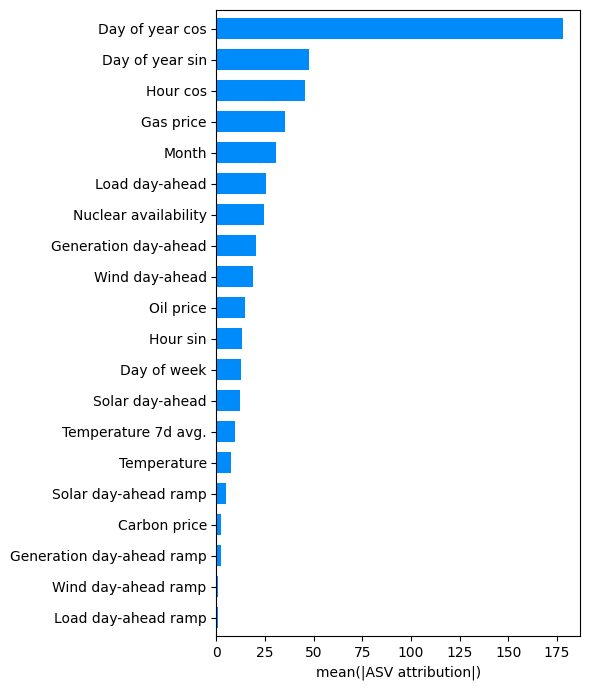

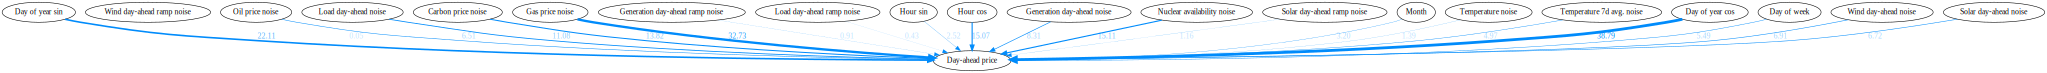

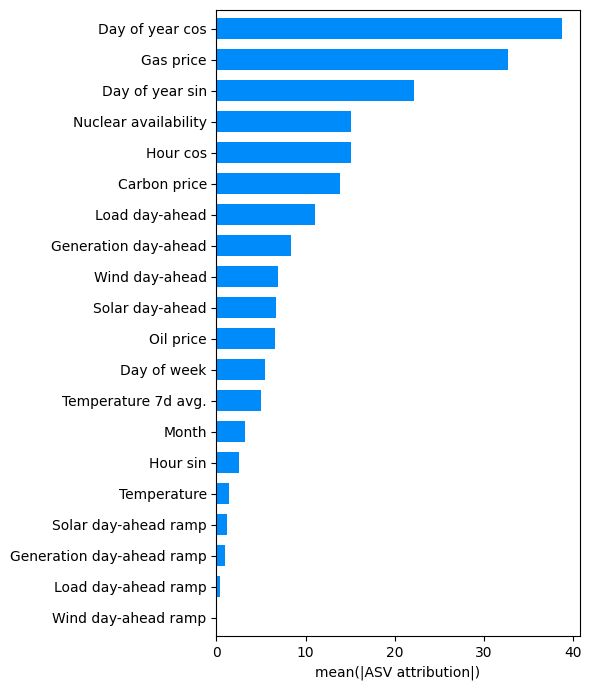

In [24]:
for i, period in enumerate(periods):
    start, end = period 
    plot_bar_mean_abs_asv(fnn_creditflow_list[i], figsize=(6, 7), save=True, name='{}_{}_{}_fnn'.format(start, end, i))

### Mean absolute SHAP (direct impact)

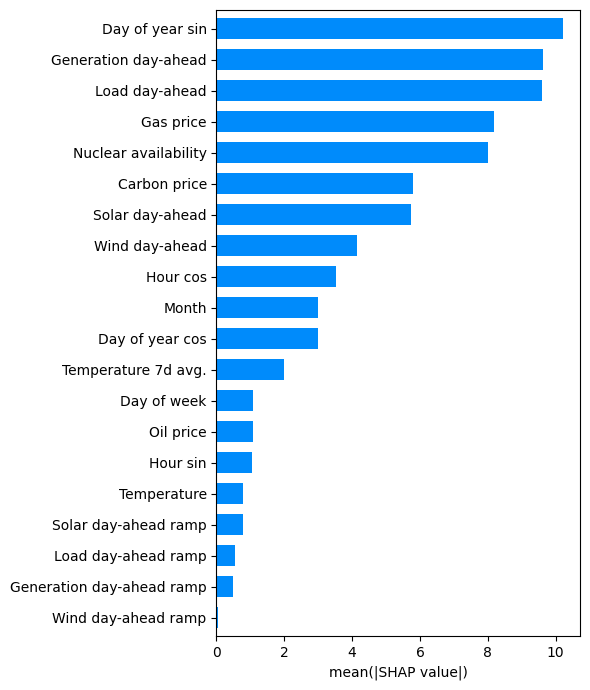

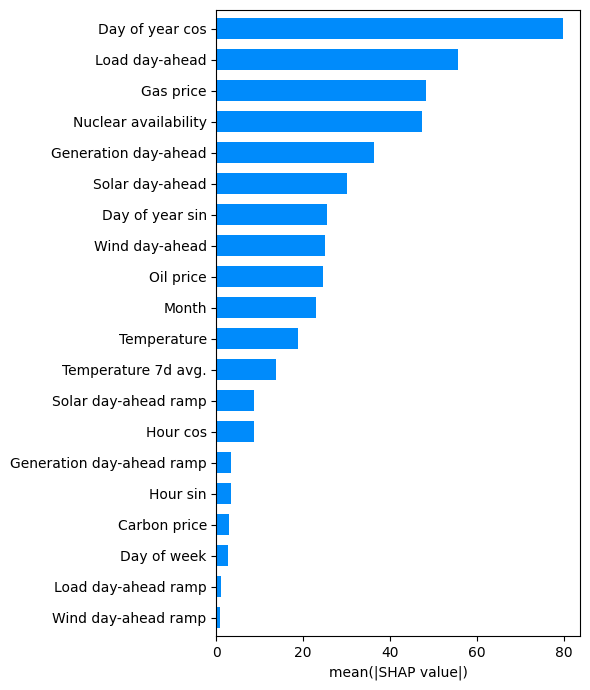

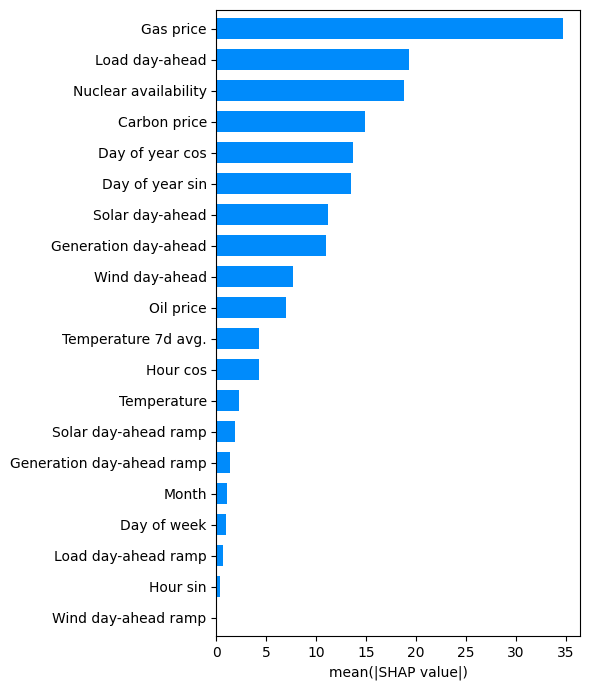

In [25]:
for i, period in enumerate(periods):
    start, end = period 
    plot_bar_mean_abs_shap(fnn_creditflow_list[i], target='Day-ahead price', figsize=(6, 7), save=True, name='{}_{}_{}_fnn'.format(start, end, i))

### Compare SHAP for different models

In [26]:
df_feature_attr = pd.DataFrame()
for i, period in enumerate(periods):
    start, end = period
    col_name = 'FNN' + start + ' to ' + end
    df_feature_attr[col_name] = get_mean_shap_attr(fnn_creditflow_list[i], 'Day-ahead price')
    df_feature_attr[col_name] = df_feature_attr[col_name]/df_feature_attr[col_name].max()

new_order = ['Month', 'Day of week', 'Day of year cos', 'Day of year sin', 'Hour cos', 'Hour sin',
    'Generation day-ahead', 'Load day-ahead', 'Solar day-ahead', 'Wind day-ahead',
    'Generation day-ahead ramp', 'Load day-ahead ramp', 'Solar day-ahead ramp', 'Wind day-ahead ramp',
    'Nuclear availability', 'Temperature', 'Temperature 7d avg.',
    'Gas price', 'Oil price', 'Carbon price']

# Reindex the DataFrame
df_feature_attr = df_feature_attr.reindex(new_order)

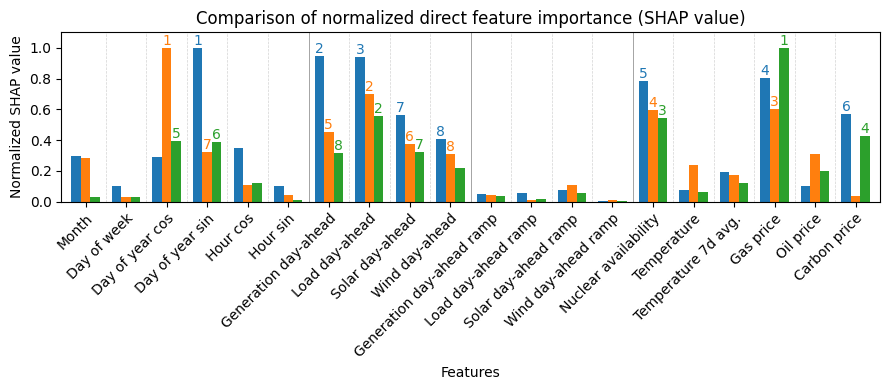

In [27]:
ax = df_feature_attr.plot(kind='bar', figsize=(9, 4), width=0.7)

plt.title("Comparison of normalized direct feature importance (SHAP value)")
plt.xlabel("Features")
plt.ylabel("Normalized SHAP value")
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.legend(title="Time Periods")
ax.legend().remove()
plt.tight_layout()


ax.set_ylim(0, 1.1)

num_features = 8

for period in df_feature_attr.columns:
    top_features = df_feature_attr.nlargest(num_features, period)

    for feature_name in top_features.index:
        bar_index = list(df_feature_attr.index).index(feature_name)
        height = df_feature_attr.at[feature_name, period]
        feature_rank = top_features.index.get_loc(feature_name) + 1

        for container in ax.containers:
            if container.get_label() == period:
                bar = container[bar_index]
                bar_color = bar.get_facecolor()
                ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), feature_rank, 
                        color=bar_color, ha='center', va='bottom', rotation=0, rotation_mode='anchor')

for i in range(len(df_feature_attr.index) - 1):
    if i in [5, 9, 13]:
        plt.axvline(x=i + 0.5, color='grey', linestyle='-', linewidth=0.5)
    else:
        plt.axvline(x=i + 0.5, color='lightgrey', linestyle='--', linewidth=0.5)

plt.show()

## dependence plots

### model 0: January 2015 - September 2021

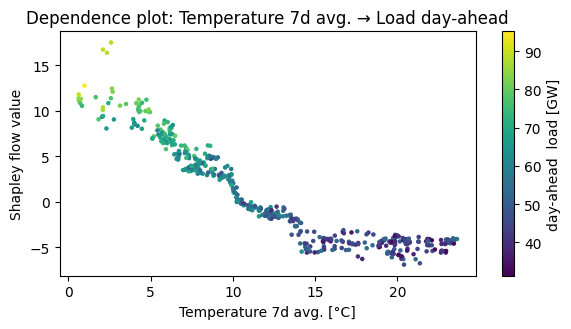

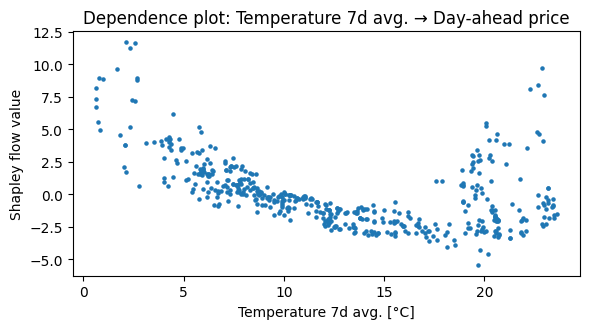

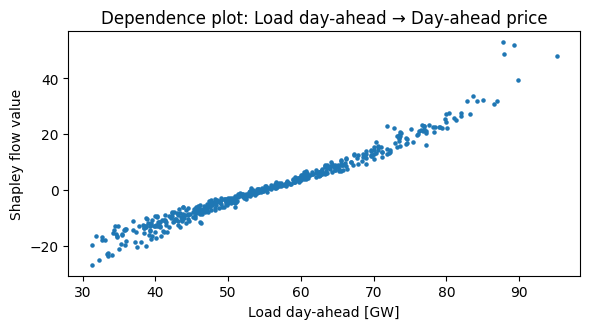

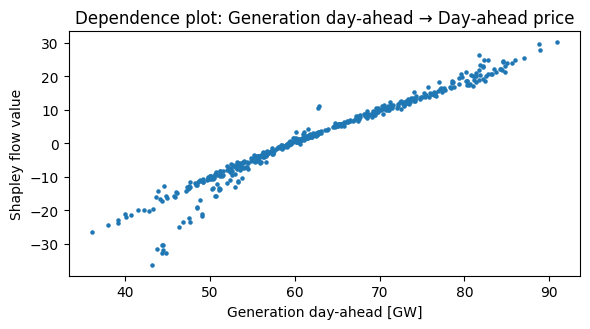

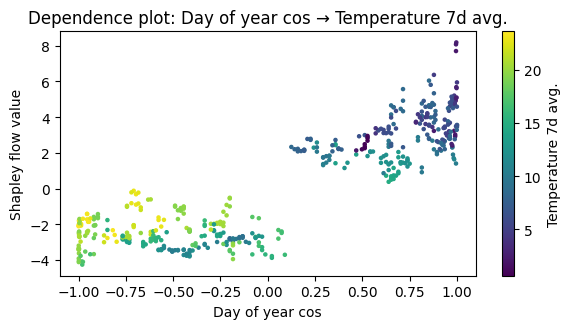

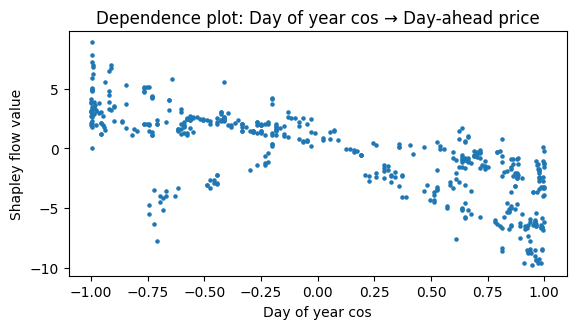

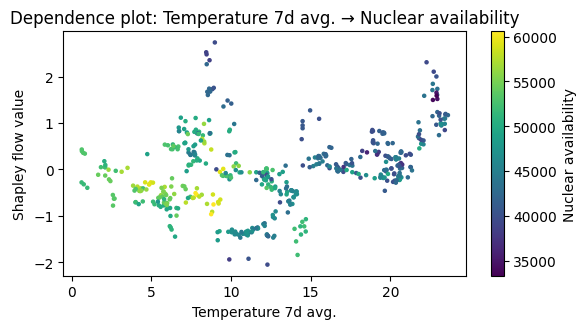

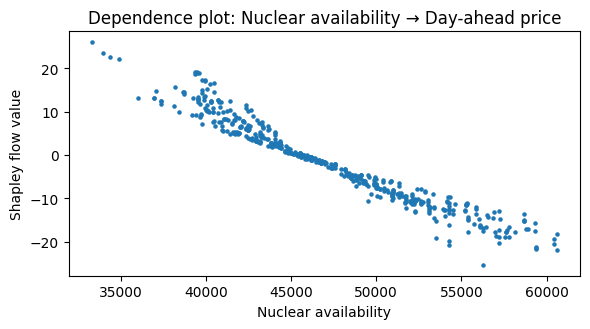

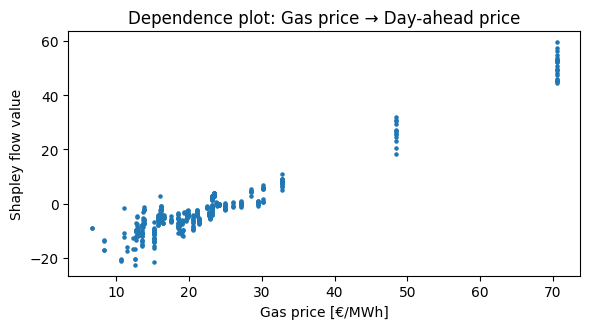

In [5]:
model_index = 0
cf = fnn_creditflow_list[model_index]
fg = fnn_fg_list[model_index]
start_date, end_date = periods[model_index]
plot_dependency(cf, 'Temperature 7d avg.', 'Load day-ahead', fg, save=True, file_name='fnn_{}_{}'.format(start_date, end_date), figsize=(6, 3.4),
                     x_label='Temperature 7d avg. [°C]', color_label='day-ahead  load [GW]',
                     scale_color=1000) # use scaling factor of 1000 for converting from MW to GW
plot_dependency(cf, 'Temperature 7d avg.', 'Day-ahead price', fg, save=True, file_name='fnn_{}_{}'.format(start_date, end_date), figsize=(6, 3.4), x_label='Temperature 7d avg. [°C]')
plot_dependency(cf, 'Load day-ahead', 'Day-ahead price', fg, save=True, file_name='fnn_{}_{}'.format(start_date, end_date), figsize=(6, 3.4), scale_x=1000, x_label='Load day-ahead [GW]')
plot_dependency(cf, 'Generation day-ahead', 'Day-ahead price', fg, save=True, file_name='fnn_{}_{}'.format(start_date, end_date), figsize=(6, 3.4), 
                scale_x=1000, x_label='Generation day-ahead [GW]', y_label='Shapley flow value')
plot_dependency(cf, 'Day of year cos', 'Temperature 7d avg.', fg, save=True, file_name='fnn_{}_{}'.format(start_date, end_date), figsize=(6, 3.4))
plot_dependency(cf, 'Day of year cos', 'Day-ahead price', fg, save=True, file_name='fnn_{}_{}'.format(start_date, end_date), figsize=(6, 3.4))
plot_dependency(cf, 'Temperature 7d avg.', 'Nuclear availability', fg, save=True, file_name='fnn_{}_{}'.format(start_date, end_date), figsize=(6, 3.4))
plot_dependency(cf, 'Nuclear availability', 'Day-ahead price', fg, save=True, file_name='fnn_{}_{}'.format(start_date, end_date), figsize=(6, 3.4))
plot_dependency(cf, 'Gas price', 'Day-ahead price', fg, save=True, file_name='fnn_{}_{}'.format(start_date, end_date), figsize=(6, 3.4),
                     x_label='Gas price [€/MWh]', scale_x=10)

### model 1: October 2021 - December 2023

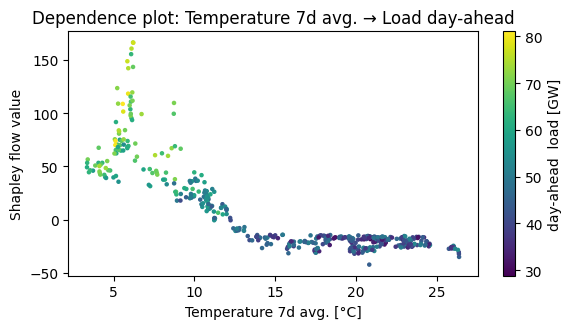

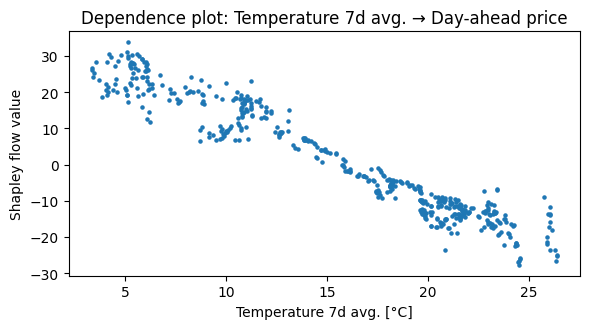

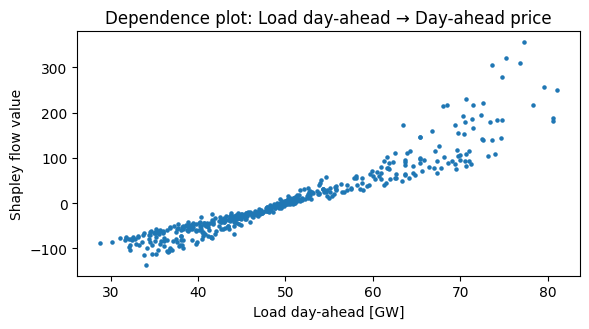

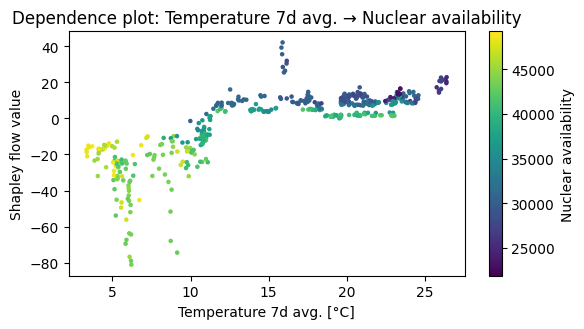

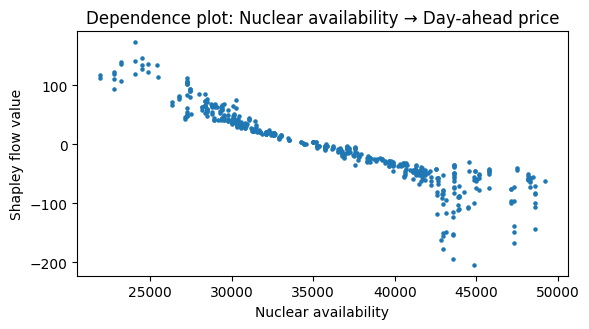

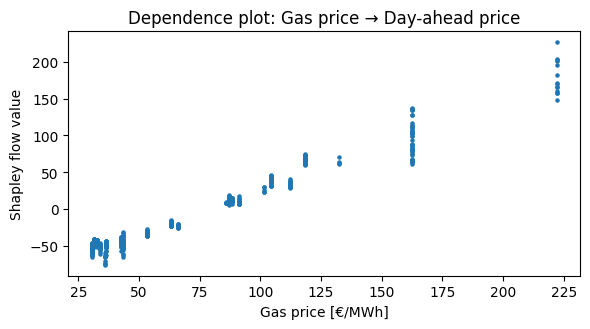

In [ ]:
model_index = 1
cf = fnn_creditflow_list[model_index]
fg = fnn_fg_list[model_index]
start_date, end_date = periods[model_index]
plot_dependency(cf, 'Temperature 7d avg.', 'Load day-ahead', fg, save=True, file_name='fnn_{}_{}'.format(start_date, end_date), figsize=(6, 3.4),
                     x_label='Temperature 7d avg. [°C]', color_label='day-ahead  load [GW]',
                     scale_color=1000) # use scaling factor of 1000 for converting from MW to GW
plot_dependency(cf, 'Temperature 7d avg.', 'Day-ahead price', fg, save=True, file_name='fnn_{}_{}'.format(start_date, end_date), figsize=(6, 3.4), x_label='Temperature 7d avg. [°C]')
plot_dependency(cf, 'Load day-ahead', 'Day-ahead price', fg, save=True, file_name='fnn_{}_{}'.format(start_date, end_date), figsize=(6, 3.4), scale_x=1000, x_label='Load day-ahead [GW]')
plot_dependency(cf, 'Temperature 7d avg.', 'Nuclear availability', fg, save=True, file_name='fnn_{}_{}'.format(start_date, end_date), figsize=(6, 3.4), x_label='Temperature 7d avg. [°C]')
plot_dependency(cf, 'Nuclear availability', 'Day-ahead price', fg, save=True, file_name='fnn_{}_{}'.format(start_date, end_date), figsize=(6, 3.4))
plot_dependency(cf, 'Gas price', 'Day-ahead price', fg, save=True, file_name='fnn_{}_{}'.format(start_date, end_date), figsize=(6, 3.4),
                      x_label='Gas price [€/MWh]', scale_x=10)

### model 2: January 2015 - December 2023

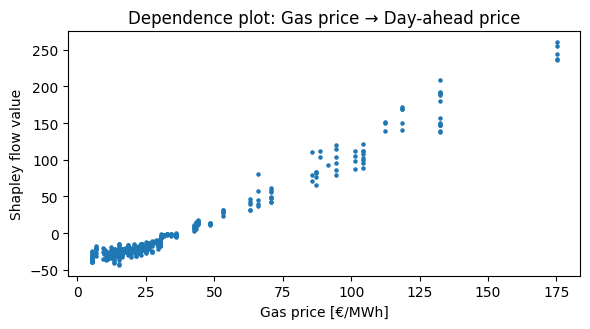

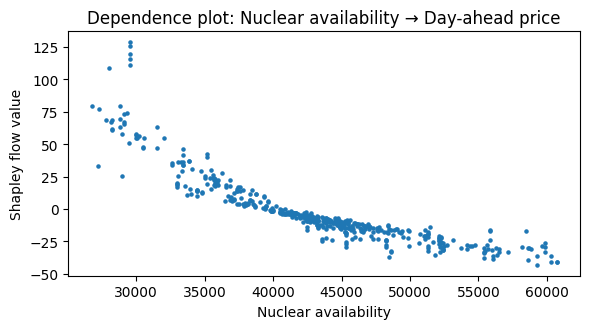

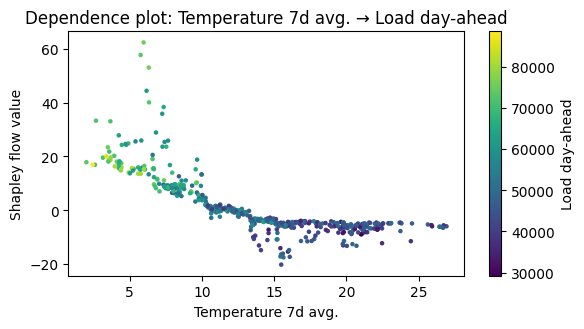

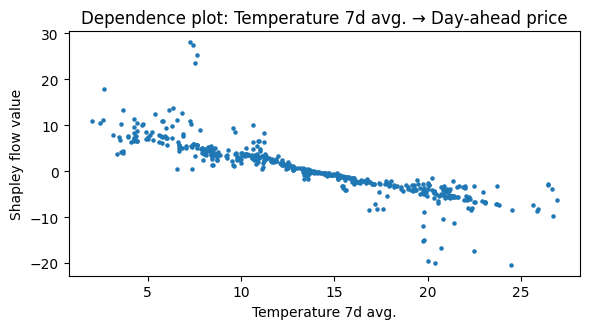

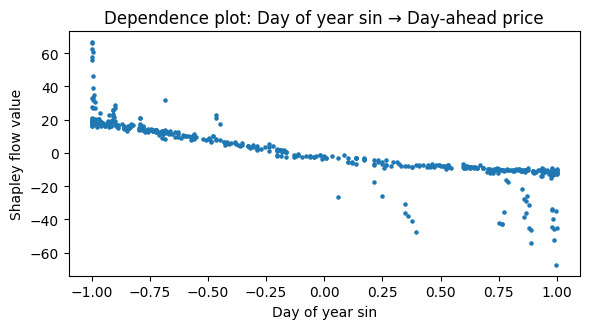

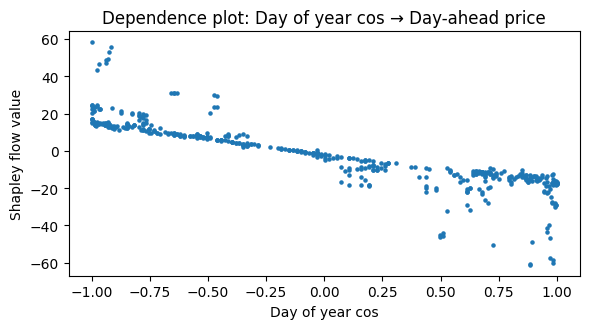

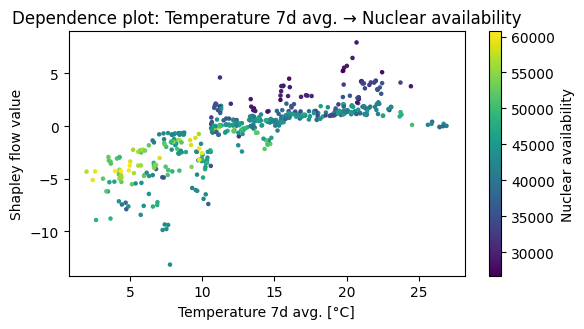

In [4]:
model_index = 2
cf = fnn_creditflow_list[model_index]
fg = fnn_fg_list[model_index]
start_date, end_date = periods[model_index]
plot_dependency(cf, 'Gas price', 'Day-ahead price', fg, save=True, file_name='fnn_{}_{}'.format(start_date, end_date), figsize=(6, 3.4),
                     y_label='Shapley flow value', x_label='Gas price [€/MWh]', scale_x=10)
plot_dependency(cf, 'Nuclear availability', 'Day-ahead price', fg, save=True, file_name='fnn_{}_{}'.format(start_date, end_date), figsize=(6, 3.4))
plot_dependency(cf, 'Temperature 7d avg.', 'Load day-ahead', fg, save=True, file_name='fnn_{}_{}'.format(start_date, end_date), figsize=(6, 3.4))
plot_dependency(cf, 'Temperature 7d avg.', 'Day-ahead price', fg, save=True, file_name='fnn_{}_{}'.format(start_date, end_date), figsize=(6, 3.4))
plot_dependency(cf, 'Day of year sin', 'Day-ahead price', fg, save=True, file_name='fnn_{}_{}'.format(start_date, end_date), figsize=(6, 3.4))
plot_dependency(cf, 'Day of year cos', 'Day-ahead price', fg, save=True, file_name='fnn_{}_{}'.format(start_date, end_date), figsize=(6, 3.4))
plot_dependency(cf, 'Temperature 7d avg.', 'Nuclear availability', fg, save=True, file_name='fnn_{}_{}'.format(start_date, end_date), figsize=(6, 3.4), x_label='Temperature 7d avg. [°C]')

# Kernel SHAP (for reference)

In [31]:
shap_values_list = []
for i, model in enumerate(fnn_model_list):
    bg_values = fnn_bg_list[i]
    fg_values = fnn_fg_list[i]
    def f(x):
        x_scaled = fnn_X_scalers[i].transform(x)
        with torch.no_grad():
            tensor = torch.tensor(x_scaled, dtype=torch.float32)
        res = model(tensor).detach().numpy().flatten()
        res_orig = fnn_y_scalers[i].inverse_transform([res])[0]
        return res_orig
    explainer = shap.KernelExplainer(f, bg_values)
    shap_values = explainer.shap_values(fg_values)
    shap_values_list.append(shap_values)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

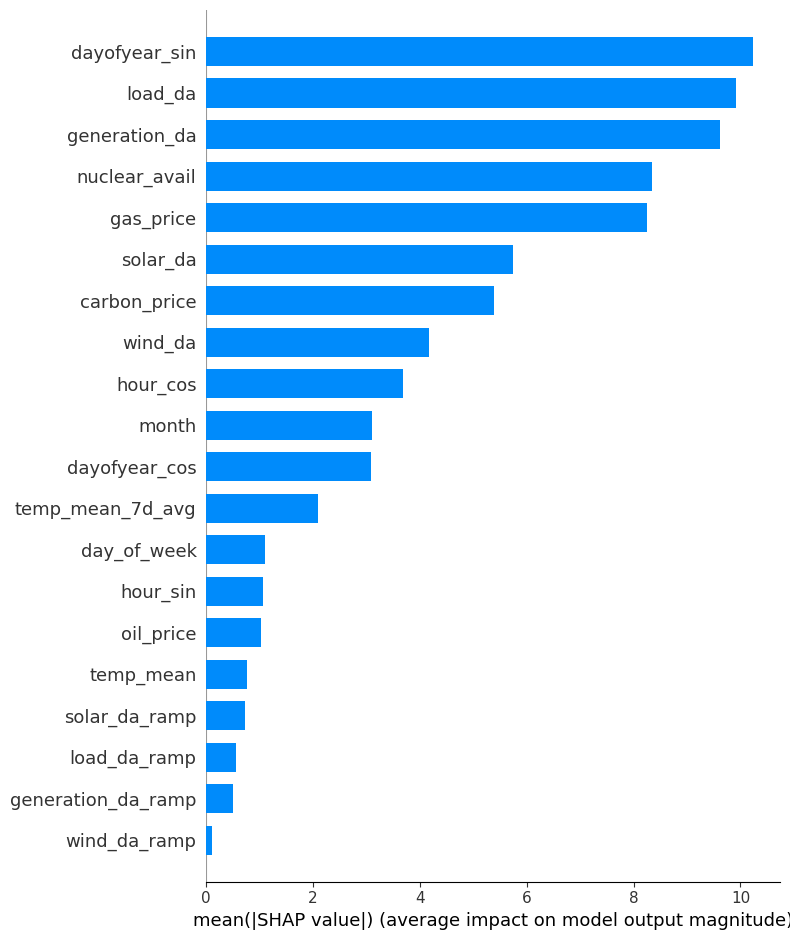

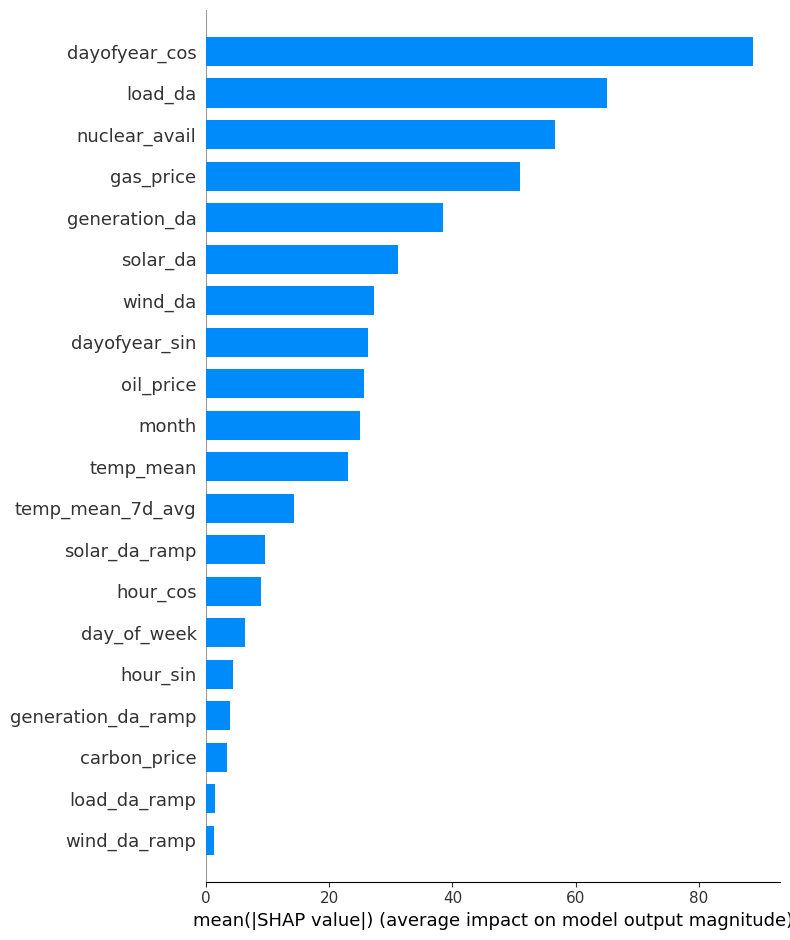

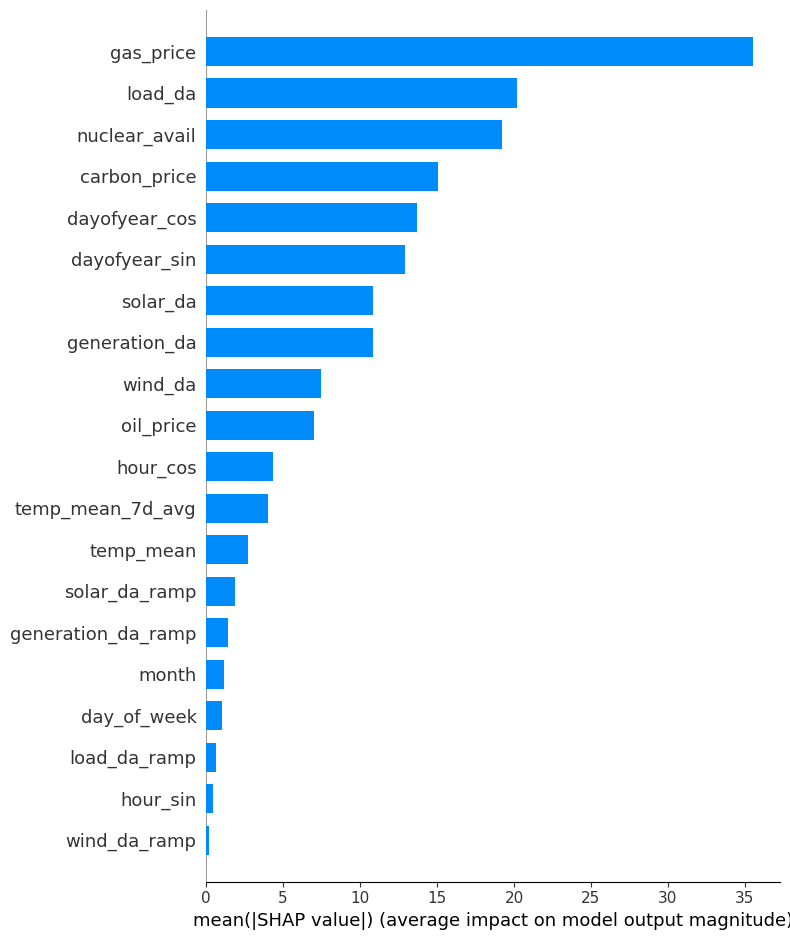

In [32]:
for i in range(3):
    shap.summary_plot(shap_values_list[i], fnn_fg_list[i], plot_type='bar', plot_size=(8, 7))

# Model Evaluation

In [35]:
for i, (start_date, end_date) in enumerate(periods):
    model = fnn_model_list[i]
    
    X_test = read_csv_incl_timeindex('./data/{}/X_test_pytorch_start_{}_end_{}.csv'.format(version, start_date, end_date))
    y_test = read_csv_incl_timeindex('./data/{}/y_test_pytorch_start_{}_end_{}.csv'.format(version, start_date, end_date))

    X_col = X_test.columns 
    X_test_transformed = fnn_X_scalers[i].transform(X_test[X_col].values)
    y_pred_tensor = model(torch.tensor(X_test_transformed, dtype=torch.float32))
    y_pred = pd.DataFrame(index=X_test.index)
    y_pred['fnn_pred'] = fnn_y_scalers[i].inverse_transform(y_pred_tensor.detach())
    r2_score_fnn = r2_score(y_test, y_pred['fnn_pred'])
    mae_fnn = mean_absolute_error(y_test, y_pred['fnn_pred'])
    mse_fnn = mean_squared_error(y_test, y_pred['fnn_pred'])
    print(start_date, end_date)
    print("R2: {:0.2f}".format(r2_score_fnn))
    print("MAE: {:0.2f}".format(mae_fnn))
    print("RMSE: {:0.2f}".format(np.sqrt(mse_fnn)))
    print("(mean label: {:0.2f})".format(y_test['price_da'].mean()))
    print("------------------------------")


2015-01-08 2021-09-30
R2: 0.88
MAE: 6.11
RMSE: 9.17
(mean label: 48.62)
------------------------------
2021-10-01 2023-12-31
R2: 0.91
MAE: 27.96
RMSE: 40.98
(mean label: 180.15)
------------------------------
2015-01-08 2023-12-31
R2: 0.92
MAE: 12.56
RMSE: 21.51
(mean label: 74.98)
------------------------------
